## Проект по дисциплине: "Анализ данных в экономике и финансах"

**Описание**

В проекте произведена выгрузка данных о текущих вакансиях с сайта [hh.ru](https://nn.hh.ru/?hhtmFrom=resume_list).
Далее произведена обработка полученных данных и создание базы данных в sqlite.
В конце работы проведен анализ требований к кандидатам и подбор вакансий, наиболее подходящих в к заданным требованиям.

**Источники**

* 2nd part url: https://habr.com/ru/post/464823/
* https://api.hh.ru/areas - список регионов
* https://github.com/hhru/api - документация
* "'Data Analyst' or 'data scientist', not 'Директор'"
* https://api.hh.ru/specializations

**Импорт пакетов**

In [2]:
import time
import requests
import pandas as pd
import numpy as np
import ast # run code from string for example ast.literal_eval("1+1") 
import sqlite3
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from nltk import word_tokenize
import nltk
from nltk.probability import FreqDist
import string
from transformers import AutoTokenizer
#библиотека схожести векторов текста
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import re
#https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html
from pandas_profiling import ProfileReport
%matplotlib inline

## Выгрузка данных

In [3]:
start_time = time.time()

number_of_pages = 100
#number_of_ads = number_of_pages * per_page

job_title = ["'data analyst' or 'data scientist' or 'data engineer' \
or 'Финансовый аналитик' or 'Финансист' or 'Финансовый консультант' or \
'анализ данных', not 'head', not 'директор', not 'director', not 'главный', \
not 'старший', not 'глава', not 'юрист', not 'менеджер'"]
for job in job_title:
    data=[]
    for i in range(number_of_pages):
        url = 'https://api.hh.ru/vacancies'
        par = {'text': job, 'area':['1', '2', '66'],'per_page':'10', 'page':i, 'only_with_salary':True}
        r = requests.get(url, params=par)
        e=r.json()
        data.append(e)
        vacancy_details = data[0]['items'][0].keys()
        df = pd.DataFrame(columns= list(vacancy_details))
        ind = 0
        for i in range(len(data)):
            for j in range(len(data[i]['items'])):
                df.loc[ind] = data[i]['items'][j]
                ind+=1
    #csv_name = "hh_base.csv"
    #df.to_csv(csv_name)

print(f"--- {(time.time() - start_time)/60} minutes ---")

--- 9.892354226112365 minutes ---


In [4]:
#hh_base = pd.read_csv('hh_base.csv')
hh_base = df

In [5]:
hh_base.sample(10)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,alternate_url,relations,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary
627,67234922,False,Координатор проекта / администратор проекта,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': None, 'to': 60000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новорязанская ул...",...,https://hh.ru/vacancy/67234922,[],"{'id': '5294004', 'name': 'Бади СК', 'url': 'h...",{'requirement': 'Высшее образование (экономиче...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
594,67161220,False,Инженер-исследователь,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': 60000, 'to': 80000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Арсенал...",...,https://hh.ru/vacancy/67161220,[],"{'id': '123255', 'name': 'Симикон', 'url': 'ht...",{'requirement': 'Навыки программирования для а...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
529,68043459,False,Программист 1С,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': 110000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Большой...",...,https://hh.ru/vacancy/68043459,[],"{'id': '2505348', 'name': 'Кингисеппский Машин...",{'requirement': 'Образование высшее. Опыт рабо...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
865,67399016,True,Менеджер по работе с ключевыми клиентами малог...,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 119300, 'to': None, 'currency': 'RUR'...","{'id': 'direct', 'name': 'Рекламная'}",None,...,https://hh.ru/vacancy/67399016,[],"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Высшее или неполное высшее об...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
810,67772265,False,Консультант - Аналитик 1С,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 150000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Скатертный переу...",...,https://hh.ru/vacancy/67772265,[],"{'id': '2552709', 'name': 'ВПТ', 'url': 'https...","{'requirement': 'Знание основ, понимание веден...",None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
302,67752357,False,Системный администратор,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 60000, 'to': 80000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'улица Золоторожс...",...,https://hh.ru/vacancy/67752357,[],"{'id': '2989765', 'name': 'ЦЛТ АБВ', 'url': 'h...",{'requirement': 'Высшее техническое образовани...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
454,67701235,False,Специалист по государственным закупкам,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 70000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'набережная Тарас...",...,https://hh.ru/vacancy/67701235,[],"{'id': '2774527', 'name': 'Государственное бюд...",{'requirement': 'Наличие высшего образование (...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
338,67250369,False,Технический писатель,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 60000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Средняя Калитник...",...,https://hh.ru/vacancy/67250369,[],"{'id': '171758', 'name': 'ФГУП РСВО', 'url': '...",{'requirement': 'Высшее профессиональное (техн...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
473,67693817,False,Верификатор,None,False,False,"{'id': '1', 'name': 'Москва'

In [6]:
hh_base = hh_base.drop(columns=['premium', 'relations', 'contacts', 'working_days', 'working_time_intervals', 'working_time_modes', 'working_days', 'working_time_intervals', 'working_time_modes', 'apply_alternate_url', 'alternate_url', 'archived', 'response_url', 'address', 'response_letter_required', 'sort_point_distance', 'address'])

In [7]:

salaries = hh_base.salary.dropna() # remove all NA's from dataframe
salaries = salaries.apply(lambda x: str(x))
currencies = [ast.literal_eval((salaries.iloc[i]))['currency'] for i in range(len(salaries))]
curr = set(currencies) #{'EUR', 'RUR', 'USD'}

#divide dataframe salararies by currency
rur = [ast.literal_eval(salaries.iloc[i]) for i in range(len(salaries)) if ast.literal_eval(salaries.iloc[i])['currency']=='RUR']
eur = [ast.literal_eval(salaries.iloc[i]) for i in range(len(salaries)) if ast.literal_eval(salaries.iloc[i])['currency']=='EUR']
usd = [ast.literal_eval(salaries.iloc[i]) for i in range(len(salaries)) if ast.literal_eval(salaries.iloc[i])['currency']=='USD']
all = [ast.literal_eval(salaries.iloc[i]) for i in range(len(salaries))]

In [8]:
fr = [x['from'] for x in all] # lower range of salary
#fr = list(filter(lambda x: if x is not None x)) # remove NA's from lower range [0, 100, 200,...]

to = [x['to'] for x in all] #upper range of salary
#to = list(filter(lambda x: x is not None, to)) #remove NA's from upper range [100, 200, 300,...]

#salary_range = list(zip(fr, to)) # concatenate upper and lower range  [(0,100), (100, 200), (200, 300)...]
#av = map(np.mean, salary_range) # convert [(0,100), (100, 200), (200, 300)...] to [50, 150, 250,...]
#for i in range(len(salary_range)):
    #salary_range[i] = round(np.mean(list(salary_range[i])),1) # average value from [50, 150, 250,...]



In [9]:
hh_base['salary_from'] = fr
hh_base['salary_to'] = to
hh_base = hh_base.drop(columns=['salary'])

In [10]:
employer_row = hh_base.loc[:,'employer']
employer = [ast.literal_eval(str(employer_row.iloc[i]))['name'] for i in range(len(employer_row))]
all_empl = set(employer)

In [11]:
hh_base['employer'] = employer

In [12]:
comp = hh_base.groupby('employer').agg({'id' : 'count'})
comp = comp.sort_values(by='id', ascending=False)
top_10 = comp.head(10)
top_10

,id
employer,
Совкомбанк,8
СБЕР,7
Ростелеком,7
Агентство судебного взыскания,6
Федеральное автономное учреждение Государственный Научно-Исследовательский Институт Авиационных Систем,6
Сеть Партнерств,6
НИКИЭТ,6
Кадровое агентство Юнити,6
"МАГНИТ, Розничная сеть",5


In [13]:
area_row = hh_base.loc[:,'area']
area = [ast.literal_eval(str(area_row.iloc[i]))['name'] for i in range(len(area_row))]
all_areas = set(area)

In [14]:
hh_base['area']= area

In [15]:
hh_base.groupby(by='name').agg({'id' : 'count'}).sort_values(by='id', ascending=False).head(10)

,id
name,
Финансовый аналитик,60
Экономист,17
Экономист-финансист,17
Системный аналитик,12
Data Engineer,12
Аналитик,10
Маркетолог,9
Бухгалтер,8
Программист 1С,8


In [16]:
hh_base.groupby(by='area').agg({'id' : 'count'})

,id
area,
Москва,739
Нижний Новгород,45
Санкт-Петербург,216


In [17]:
hh_base.columns

Index(['id', 'name', 'department', 'has_test', 'area', 'type', 'published_at',
       'created_at', 'insider_interview', 'url', 'adv_response_url',
       'employer', 'snippet', 'schedule', 'accept_temporary', 'salary_from',
       'salary_to'],
      dtype='object')

In [18]:
hh_base[hh_base['name'] == 'Аналитик']

,id,name,department,has_test,area,type,published_at,created_at,insider_interview,url,adv_response_url,employer,snippet,schedule,accept_temporary,salary_from,salary_to
264,67905370,Аналитик,None,False,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2022-07-19T10:51:14+0300,2022-07-19T10:51:14+0300,None,https://api.hh.ru/vacancies/67905370?host=hh.ru,https://api.hh.ru/vacancies/67905370/adv_respo...,Акваарт,{'requirement': 'Умение работать с большими об...,"{'id': 'fullDay', 'name': 'Полный день'}",False,NaN,150000.0
345,67406169,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-22T13:38:17+0300,2022-07-22T13:38:17+0300,None,https://api.hh.ru/vacancies/67406169?host=hh.ru,https://api.hh.ru/vacancies/67406169/adv_respo...,Региональная Сеть Предприятий Питания,{'requirement': 'Опыт работы в маркетинге (око...,"{'id': 'fullDay', 'name': 'Полный день'}",False,NaN,145000.0
370,67289764,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-22T13:25:08+0300,2022-07-22T13:25:08+0300,None,https://api.hh.ru/vacancies/67289764?host=hh.ru,https://api.hh.ru/vacancies/67289764/adv_respo...,Городская Мобильность,{'requirement': 'Опыт работы <highlighttext>ан...,"{'id': 'fullDay', 'name': 'Полный день'}",False,NaN,120000.0
445,67394074,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-22T09:37:14+0300,2022-07-22T09:37:14+0300,None,https://api.hh.ru/vacancies/67394074?host=hh.ru,https://api.hh.ru/vacancies/67394074/adv_respo...,СП Торг,{'requirement': '...<highlighttext>данных</hig...,"{'id': 'fullDay', 'name': 'Полный день'}",False,100000.0,150000.0
476,67387717,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-22T03:57:03+0300,2022-07-22T03:57:03+0300,None,https://api.hh.ru/vacancies/67387717?host=hh.ru,https://api.hh.ru/vacancies/67387717/adv_respo...,ПРАЙМ ГРУП,{'requirement': 'Опыт работы на проектах в дол...,"{'id': 'fullDay', 'name': 'Полный день'}",False,180000.0,200000.0
700,67351002,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-20T17:46:10+0300,2022-07-20T17:46:10+0300,None,https://api.hh.ru/vacancies/67351002?host=hh.ru,https://api.hh.ru/vacancies/67351002/adv_respo...,ТопДеливери,{'requirement': 'Опыт работы с BI системами в ...,"{'id': 'remote', 'name': 'Удаленная работа'}",False,NaN,70000.0
719,67137776,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-20T19:28:10+0300,2022-07-20T19:28:10+0300,None,https://api.hh.ru/vacancies/67137776?host=hh.ru,https://api.hh.ru/vacancies/67137776/adv_respo...,Инвест МСК,"{'requirement': 'Внимательность, ответственнос...","{'id': 'fullDay', 'name': 'Полный день'}",False,50000.0,70000.0
727,67513390,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-20T18:05:17+0300,2022-07-20T18:05:17+0300,None,https://api.hh.ru/vacancies/67513390?host=hh.ru,https://api.hh.ru/vacancies/67513390/adv_respo...,АйДи-360,{'requirement': 'Высшее образование. Опыт рабо...,"{'id': 'remote', 'name': 'Удаленная работа'}",False,NaN,90000.0
995,66527323,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-18T10:08:02+0300,2022-07-18T10:08:02+0300,None,https://api.hh.ru/vacancies/66527323?host=hh.ru,https://api.hh.ru/vacancies/66527323/adv_respo...,HR Consulting,{'requirement': 'Высшее образование (маркетинг...,"{'id': 'fullDay', 'name': 'Полный день'}",False,100000.0,150000.0
996,67887707,Аналитик,None,False,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-18T18:07:29+0300,2022-07-18T18:07:29+0300,None,https://api.hh.ru/vacancies/67887707?host=hh.ru,https://api.hh.ru/vacancies/67887707/adv_respo...,Национальные телематические системы,{'requirement': 'Опыт работы в разработке ПО о...,"{'id': 'fullDay', 'name': 'Полный день'}",False,150000.0,NaN


In [19]:
describe = hh_base.loc[:,'snippet']
requirement = [ast.literal_eval(str(describe.iloc[i]))['requirement'] for i in range(len(describe))]
hh_base['snippet'] = requirement

In [20]:
hh_base['salary'] = (hh_base['salary_from'] + hh_base['salary_to']) / 2

In [21]:
hh_base.loc[:,['salary_from','salary_to']] = hh_base.loc[:,['salary_from','salary_to']].fillna(0)
hh_base['sum_sal'] = hh_base['salary_from'] + hh_base['salary_to']

In [22]:
hh_base['salary'] = hh_base['salary'].fillna(value=hh_base['sum_sal'])

In [23]:
hh_base['salary'].isna().value_counts()

False    1000
Name: salary, dtype: int64

In [24]:
hh_base.groupby('name', as_index=False).agg({'salary' : 'median', 'id': 'count'}).sort_values(by='salary', ascending=False).head(10)

,name,salary,id
389,Менеджер по продажам (инвестиционный/финансовы...,850000.0,1
40,Data Techlead / Lead Data Engineer / Data Analyst,500000.0,1
191,Архитектор (Data/ETL),495000.0,1
72,ML Engineer \ Data scientist,450000.0,1
454,Разработчик C# / Python,400000.0,2
624,Финансовый директор,400000.0,1
118,"Senior Software Engineer, Database Engine (Jav...",400000.0,1
119,"Senior Software Engineer, Database Engine (Jav...",400000.0,1
89,Python TechLead,400000.0,1
34,Data Scientist ( remote job ),400000.0,1


In [25]:
hh_base = hh_base.drop(columns=['sum_sal', 'salary_from','salary_to'])


In [26]:
schedule = hh_base.loc[:,'schedule']
schedule = [ast.literal_eval(str(schedule.iloc[i]))['name'] for i in range(len(schedule))]
hh_base['schedule'] = schedule

In [27]:
hh_base['schedule'].value_counts()

Полный день         811
Удаленная работа    122
Гибкий график        46
Сменный график       20
Вахтовый метод        1
Name: schedule, dtype: int64

In [28]:
#hh_base.to_csv(r'hh_formatted.csv', index=None, header=True)

In [29]:
hh_base = hh_base.drop(columns=['accept_temporary','has_test'])

In [30]:
hh_base.dtypes

id                    object
name                  object
department            object
area                  object
type                  object
published_at          object
created_at            object
insider_interview     object
url                   object
adv_response_url      object
employer              object
snippet               object
schedule              object
salary               float64
dtype: object

## Работа с sqlite

In [31]:
#sql
conn = sqlite3.connect('hh.sqlite')
cur = conn.cursor()

In [32]:
cur.executescript('''DROP TABLE hh_base''')

In [33]:
cur.executescript('''


CREATE TABLE IF NOT EXISTS hh_base (
    id                     INTEGER,
name                  TEXT,
department            TEXT,
area                  TEXT,
type                  TEXT,
published_at          TEXT,
created_at            TEXT,
insider_interview     TEXT,
url                   TEXT,
employer              TEXT,
snippet               TEXT,
schedule              TEXT,
salary                DECIMAL
);
''')

In [34]:
for i in range(hh_base.shape[0]):
    #print(i, end = ' ')
    cur.execute('''
    INSERT INTO hh_base (
            id,
            name,
            department,
            area,
            type,
            published_at,
            created_at,
            insider_interview,
            url,
            employer ,
            snippet,
            schedule ,
            salary         
                    )
    VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?);''', # 13 столбцов
            (int(hh_base.iloc[i,0]),
             hh_base.iloc[i,1],
             str(hh_base.iloc[i,2]),
             hh_base.iloc[i,3],
             str(hh_base.iloc[i,4]),
             hh_base.iloc[i,5],
             hh_base.iloc[i,6],
             str(hh_base.iloc[i,7]),
             hh_base.iloc[i,8],
             hh_base.iloc[i,10],
             hh_base.iloc[i,11],
             hh_base.iloc[i,12],
             hh_base.iloc[i,13],
            )) 

In [35]:
hh_base['area'].value_counts()

Москва             739
Санкт-Петербург    216
Нижний Новгород     45
Name: area, dtype: int64

In [36]:
cur.execute('''
select area as Город, avg(salary) as Средняя_зарплата
from hh_base
group by area
;
''')
pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])


,Город,Средняя_зарплата
0,Москва,122748.403248
1,Нижний Новгород,65746.666667
2,Санкт-Петербург,85739.557870


In [37]:
cur.execute('''
select id,
            name,
            department,
            area,
            type,
            published_at,
            created_at,
            url,
            employer,
            snippet,
            schedule ,
            salary    
from hh_base
where name like 'Financ%' or name like 'Финанс%' or name like '%финанс%' or name like '%financ%' or name like 'финанс%' or name like 'financ%'
order by salary;
''')
finansists = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
#finansists.to_csv(r'finansists.csv', index=None, header=True)

In [38]:
cur.execute('''
select id,
            name,
            department,
            area,
            type,
            published_at,
            created_at,
            insider_interview,
            url,
            employer ,
            snippet,
            schedule ,
            salary    
from hh_base
where name like 'Data%' or name like '%данны%' or name like '%data%' or name like '%Data%' or name like '%Данны%' or name like '%Data'

;
''')
Data_scientists = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
#Data_scientists.to_csv(r'Data_scientists.csv', index=None, header=True)

In [39]:
Data_scientists.sample(5)

,id,name,department,area,type,published_at,created_at,insider_interview,url,employer,snippet,schedule,salary
47,67932062,"Помощник экономиста, специалист по работе с ба...",None,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2022-07-22T14:56:12+0300,2022-07-22T14:56:12+0300,None,https://api.hh.ru/vacancies/67932062?host=hh.ru,Булочные Ф.Вольчека,Высшее экономическое или математическое образо...,Полный день,42500
106,67744853,"Программист C++ (разработка алгоритмов, анализ...",None,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2022-07-13T14:58:39+0300,2022-07-13T14:58:39+0300,None,https://api.hh.ru/vacancies/67744853?host=hh.ru,Аквамарин,Профильное высшее образование. Знание C++. Зна...,Полный день,112500
141,66829547,Middle ML / Data Science разработчик,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-07T15:55:16+0300,2022-07-07T15:55:16+0300,None,https://api.hh.ru/vacancies/66829547?host=hh.ru,Центр хранения и анализа больших данных,Высшее техническое образование (оконченное). Л...,Гибкий график,170000
67,67732357,"Senior Software Engineer, Database Engine (Jav...",None,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2022-07-22T11:26:08+0300,2022-07-22T11:26:08+0300,None,https://api.hh.ru/vacancies/67732357?host=hh.ru,Querify Labs,Experience with parallel algorithms and concur...,Удаленная работа,400000
38,67439152,Data expert / Главный эксперт по анализу данных,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-22T09:26:13+0300,2022-07-22T09:26:13+0300,None,https://api.hh.ru/vacancies/67439152?host=hh.ru,Double Data,Вы имеете релевантный опыт сбора и/или <highli...,Удаленная работа,375000


In [40]:
hh_base.head(2)

,id,name,department,area,type,published_at,created_at,insider_interview,url,adv_response_url,employer,snippet,schedule,salary
0,67709935,Финансовый аналитик,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-23T08:17:00+0300,2022-07-23T08:17:00+0300,None,https://api.hh.ru/vacancies/67709935?host=hh.ru,https://api.hh.ru/vacancies/67709935/adv_respo...,Staffline,Опыт работы <highlighttext>финансовым</highlig...,Полный день,150000.0
1,55104266,Финансовый аналитик,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-22T19:08:30+0300,2022-07-22T19:08:30+0300,None,https://api.hh.ru/vacancies/55104266?host=hh.ru,https://api.hh.ru/vacancies/55104266/adv_respo...,Фонд развития промышленности,...<highlighttext>анализа</highlighttext> инве...,Полный день,160000.0


In [41]:
cur.execute('''
select 
            area,
            schedule as 'Режим работы' ,
            count(schedule) as 'Кол-во вакансий' 
from hh_base
group by area, schedule
;
''')
schedule = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
schedule.head(2)
#schedule.to_csv(r'schedule.csv', index=None, header=True)

,area,Режим работы,Кол-во вакансий
0,Москва,Вахтовый метод,1
1,Москва,Гибкий график,27


## Анализ вакансий

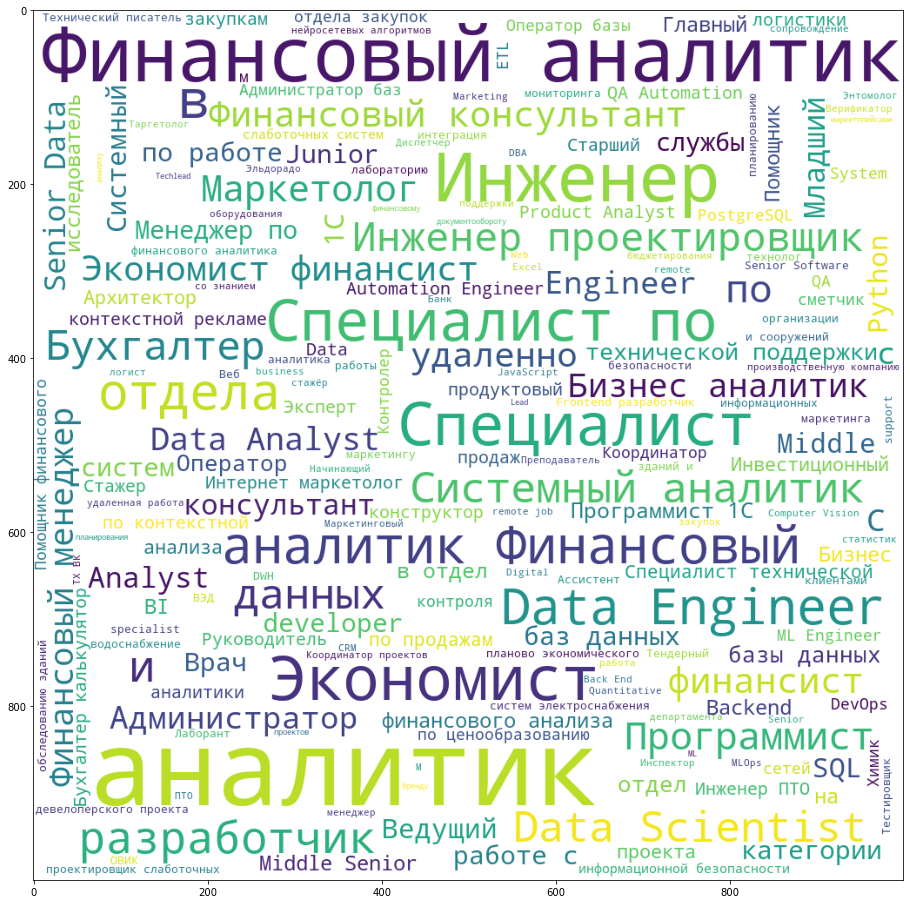

In [42]:
#сравниваем таблицы: исходную и обработанные в SQL


vacancy_names =  hh_base.name # change here to change source of data/words etc
cloud = Counter(vacancy_names)
from wordcloud import WordCloud
#stopwords = stopwords.words('russian')
cloud = ''
for x in list(vacancy_names):
    cloud+=x+' '
wordcloud = WordCloud(width = 1000, height = 1000, 

                stopwords = STOPWORDS, 
                min_font_size = 2,background_color='white'
                     ).generate(cloud)

pylab.figure(figsize = (16, 16)) 
pylab.imshow(wordcloud)

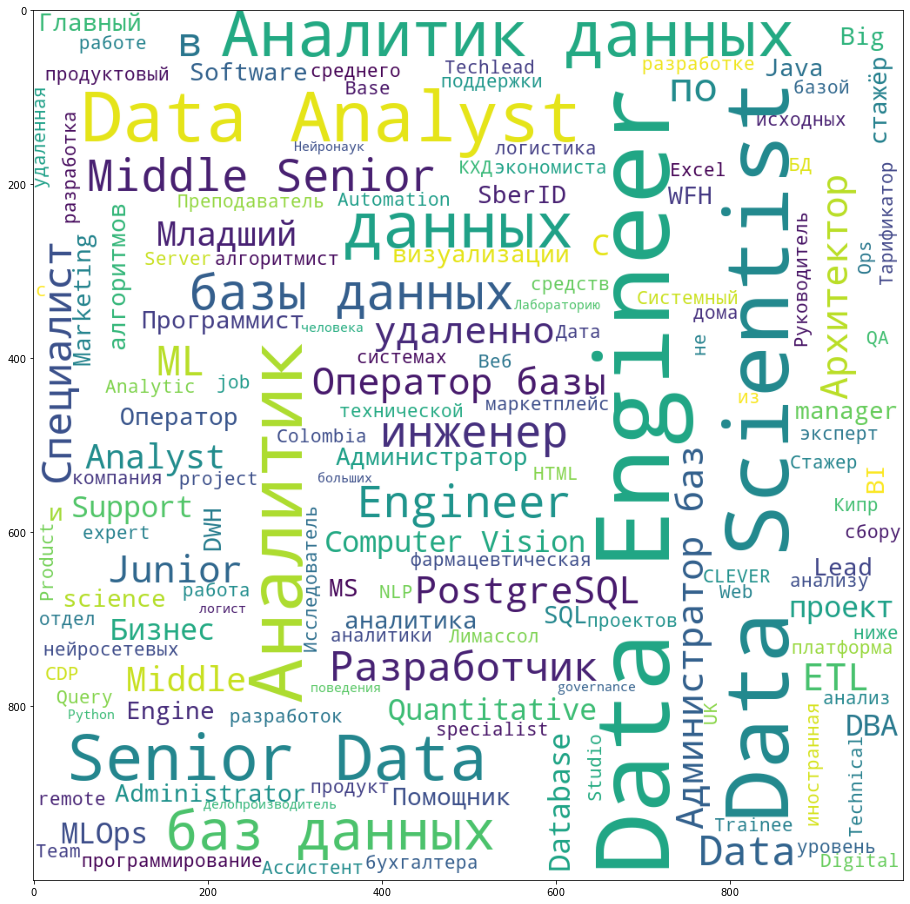

In [43]:

vacancy_names =  Data_scientists.name # change here to change source of data/words etc
cloud = Counter(vacancy_names)
stopwords = set(STOPWORDS)
cloud = ''
for x in list(vacancy_names):
    cloud+=x+' '
wordcloud_2 = WordCloud(width = 1000, height = 1000, 

                stopwords = stopwords, 
                min_font_size = 8,background_color='white'
                     ).generate(cloud)

plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud_2)
#plt.savefig('Data scientists_cloud.png')

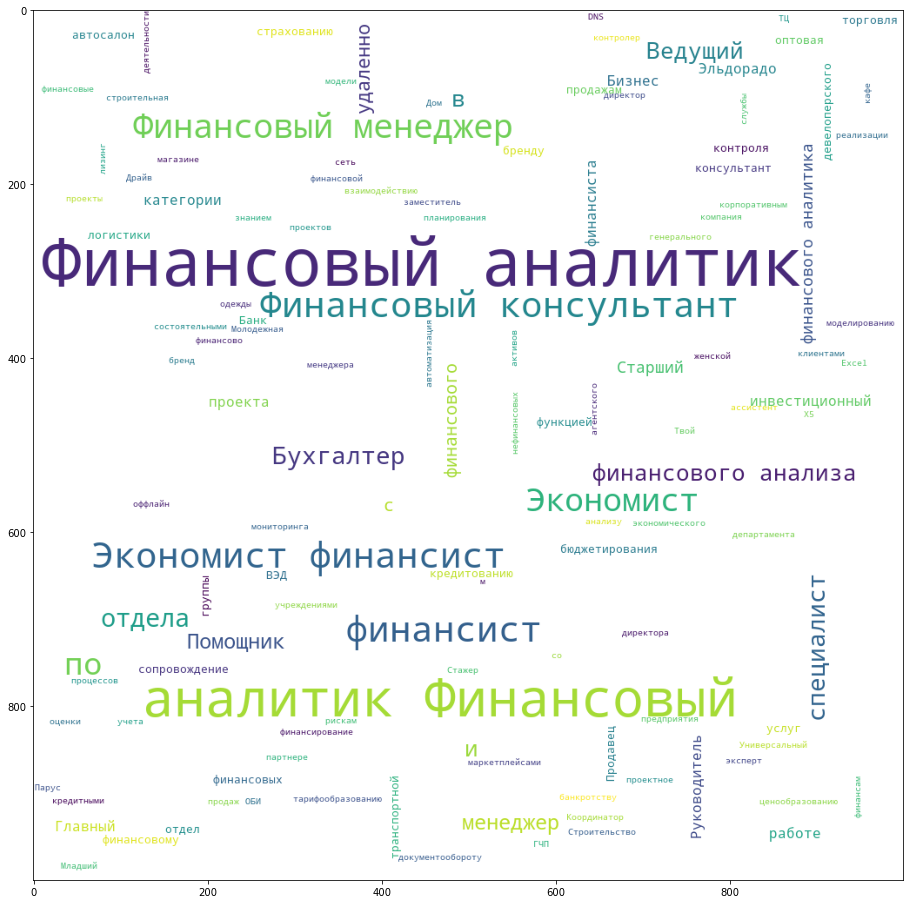

In [44]:

vacancy_names =  finansists.name # change here to change source of data/words etc
cloud = Counter(vacancy_names)
stopwords = set(STOPWORDS)
cloud = ''
for x in list(vacancy_names):
    cloud+=x+' '
wordcloud_3 = WordCloud(width = 1000, height = 1000, 

                stopwords = stopwords, 
                min_font_size = 8,background_color='white'
                     ).generate(cloud)

plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud_3)
#plt.savefig('finansists_cloud.png')

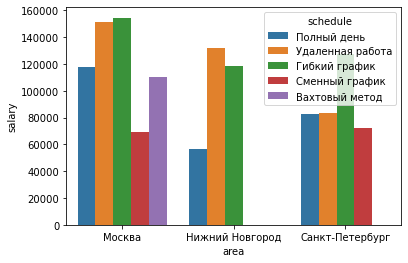

In [45]:

sns.barplot(
    x="area", 
    y="salary", 
    hue='schedule',
    ci=None,
    capsize=0.001,
    data=hh_base
);

#plt.savefig('hh_salaries.png')

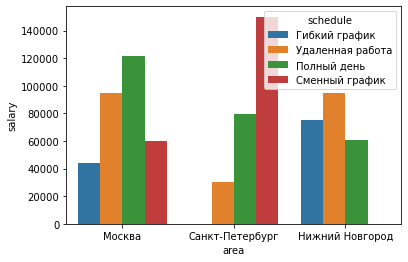

In [46]:
sns.barplot(
    x="area", 
    y="salary", 
    hue='schedule',
    ci=None, 
    data=finansists,
    capsize=0.8
);
#plt.savefig('fin_salaries.png')

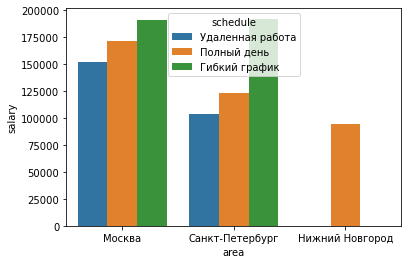

In [47]:
sns.barplot(
    x="area", 
    y="salary", 
    hue='schedule',
    ci=None, 
    
    data=Data_scientists
);

#plt.savefig('Data_salaries.png')

In [48]:
lst_no = ['.', ',', ':', '!', '"', "'", '[', ']', '-', '—', '(', ')', '?', '_', '`', '<', '>' ]   # и т.д.
lst = []

for word in str(list(hh_base['snippet'])).lower().split():
    if not word in lst_no:
        _word = word 
        if word[-1] in lst_no:
            _word = _word[:-1]
        if word[0] in lst_no:
            _word = _word[1:] 
        lst.append(_word)

_dict = dict()
for word in lst:
    _dict[word] = _dict.get(word, 0) + 1

# сортируем словарь посредством формирования списка (значение, ключ)
_list = []
for key, value in _dict.items():
    _list.append((value, key))
    _list.sort(reverse=True)

# самое частое слово в этом тексте
print(f'самое частое слово в этом тексте -> `{_list[0][1]}`, использовалось `{_list[0][0]}` раз.')

самое частое слово в этом тексте -> `опыт`, использовалось `744` раз.


In [49]:
#_list

In [50]:
text = str(list(hh_base['snippet']))
text = text.lower()
spec_chars = string.punctuation + '...n' + 'highlighttext'
text = "".join([ch for ch in text if ch not in spec_chars])
print(len(text))
text_tokens = word_tokenize(text)
print(len(text_tokens))

140370
18414


In [51]:
text = nltk.Text(text_tokens)

In [52]:
fdist = FreqDist(text)

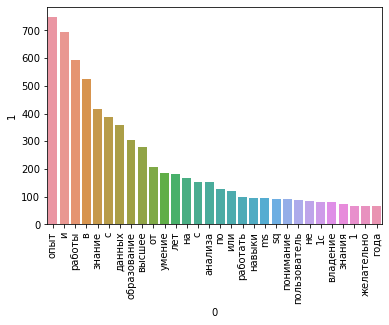

In [53]:

most_common = pd.DataFrame(fdist.most_common(30))
x=most_common.loc[:,0]
y=most_common.loc[:,1]
plot = sns.barplot(x=x, y=y)
labels = plot.set_xticklabels(x, rotation=90)
#plt.savefig('Skills_bar.png')

In [54]:
len(text)

18414

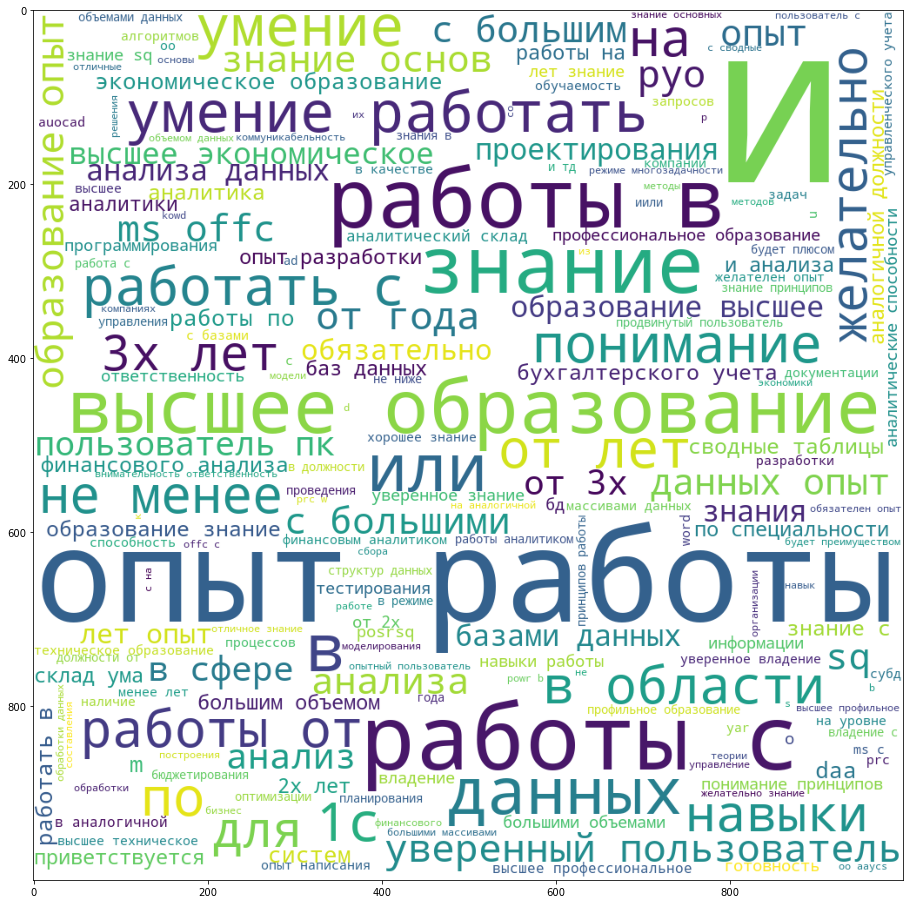

In [55]:

skills =  text_tokens # change here to change source of data/words etc
cloud = Counter(skills)
stopwords = set(STOPWORDS)
cloud = ''
for x in list(skills):
    cloud+=x+' '
wordcloud = WordCloud(width = 1000, height = 1000, 

                stopwords = stopwords, 
                min_font_size = 2,background_color='white'
                     ).generate(cloud)

plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud)
#plt.savefig('skills.png')

In [56]:
profile = ProfileReport(hh_base, title="Статистика по вакансиям Data Scientists и Финансовый аналитик в НН, СПБ и МСК", explorative=True)
profile.to_widgets()

In [57]:
#profile.to_file("hh_report.html")

## Поиск подходящих вакансий по набору навыков

In [59]:
#указать навыки в виде списка
monkey_skills = ['Уровень знания английского: upper intermediate',
'Уверенный пользователь ПК (Microsoft Office: Excel, Word, PowerPoint)',
'Грамотная устная и письменная речь',
'Владение Python. Библиотеки: scikit-learn, numpy, pandas, matplotlib.',
'SQL',
'Eviews',
'Корпоративные финансы', 'эконометрика'
]

In [60]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

In [61]:
#преобразование предложений в вектора
candidate_skills = tokenizer.encode(str(monkey_skills),  max_length=2000, truncation=True, padding='max_length', return_tensors='pt')
candidate_skills

tensor([[ 101, 1031, 1005,  ...,    0,    0,    0]])

In [75]:
text_list = list(hh_base['snippet'])
spec_chars = string.punctuation + '...n' + 'highlighttext'
for i in range(len(text_list)):
    text_list[i] = str(text_list[i])
    text_list[i] = "".join([ch for ch in text if ch not in spec_chars])

In [63]:
#text_list = list(hh_base['snippet'])
#spec_chars = string.punctuation + '...n' + 'highlighttext'
#for i in range(len(text_list)):
#    text_list[i] = str(text_list[i])

In [64]:
#for i in range(len(text_list)):    
#    text_list[i] = "".join([ch for ch in text_list[i] if ch not in spec_chars])

In [76]:
#for i in range(len(text_list)):
#    text_list[i] = word_tokenize(text_list[i])

In [77]:
for i in range(len(text_list)):
    text_list[i] = tokenizer.encode(text_list[i], max_length=2000, truncation=True, padding='max_length', return_tensors='pt')

In [78]:

for i in range(len(text_list)):
    text_list[i] = cosine_similarity(candidate_skills,text_list[i])

In [80]:
#text_list = pd.DataFrame(text_list).fillna(value='Нет данных')
#text_list = list(text_list)

In [83]:
#text_list = pd.DataFrame(text_list)

In [82]:
hh_base['similarity'] = text_list

In [84]:
top_suitable = hh_base.sort_values(by='similarity', ascending=False).head(100)
#export_csv = top_suitable.to_csv(r'top_suitable.csv', index=None, header=True)

In [86]:
top_suitable.head(10)

,id,name,department,area,type,published_at,created_at,insider_interview,url,adv_response_url,employer,snippet,schedule,salary,similarity
0,67709935,Финансовый аналитик,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-23T08:17:00+0300,2022-07-23T08:17:00+0300,None,https://api.hh.ru/vacancies/67709935?host=hh.ru,https://api.hh.ru/vacancies/67709935/adv_respo...,Staffline,Опыт работы <highlighttext>финансовым</highlig...,Полный день,150000.0,[[0.28925392422215923]]
671,67525465,Аналитик данных (стажёр),None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-06T09:36:58+0300,2022-07-06T09:36:58+0300,None,https://api.hh.ru/vacancies/67525465?host=hh.ru,https://api.hh.ru/vacancies/67525465/adv_respo...,Правительство Москвы,Неоконченное (3-4 курс бакалавриата)/оконченно...,Полный день,49200.0,[[0.28925392422215923]]
658,67226992,Инженер-проектировщик ОВИК,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-21T08:42:40+0300,2022-07-21T08:42:40+0300,None,https://api.hh.ru/vacancies/67226992?host=hh.ru,https://api.hh.ru/vacancies/67226992/adv_respo...,ЛИМАКМАРАЩСТРОЙ,Профильное высшее образование. Опыт работы в о...,Полный день,70000.0,[[0.28925392422215923]]
659,67359206,Маркетолог,None,Нижний Новгород,"{'id': 'open', 'name': 'Открытая'}",2022-07-21T09:03:37+0300,2022-07-21T09:03:37+0300,None,https://api.hh.ru/vacancies/67359206?host=hh.ru,https://api.hh.ru/vacancies/67359206/adv_respo...,Агротрейд Техником,Теоретические основы маркетинга и менеджмента....,Полный день,50000.0,[[0.28925392422215923]]
660,50996601,Инженер-проектировщик систем электроснабжения,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-21T08:42:15+0300,2022-07-21T08:42:15+0300,None,https://api.hh.ru/vacancies/50996601?host=hh.ru,https://api.hh.ru/vacancies/50996601/adv_respo...,Смарт Констракшн,Проектирование систем электроснабжения центров...,Полный день,102000.0,[[0.28925392422215923]]
661,55423072,Финансовый консультант / Руководитель агентско...,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-15T13:22:32+0300,2022-07-15T13:22:32+0300,None,https://api.hh.ru/vacancies/55423072?host=hh.ru,https://api.hh.ru/vacancies/55423072/adv_respo...,PPF Страхование жизни,Умение вести переговоры. Умение работать в ком...,Полный день,80000.0,[[0.28925392422215923]]
662,67685146,Врач-уролог,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-21T09:58:03+0300,2022-07-21T09:58:03+0300,None,https://api.hh.ru/vacancies/67685146?host=hh.ru,https://api.hh.ru/vacancies/67685146/adv_respo...,Личный доктор,Высшее медицинское профессиональное образовани...,Гибкий график,120000.0,[[0.28925392422215923]]
663,67226992,Инженер-проектировщик ОВИК,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-21T08:42:40+0300,2022-07-21T08:42:40+0300,None,https://api.hh.ru/vacancies/67226992?host=hh.ru,https://api.hh.ru/vacancies/67226992/adv_respo...,ЛИМАКМАРАЩСТРОЙ,Профильное высшее образование. Опыт работы в о...,Полный день,70000.0,[[0.28925392422215923]]
664,67359206,Маркетолог,None,Нижний Новгород,"{'id': 'open', 'name': 'Открытая'}",2022-07-21T09:03:37+0300,2022-07-21T09:03:37+0300,None,https://api.hh.ru/vacancies/67359206?host=hh.ru,https://api.hh.ru/vacancies/67359206/adv_respo...,Агротрейд Техником,Теоретические основы маркетинга и менеджмента....,Полный день,50000.0,[[0.28925392422215923]]
665,66511047,Специалист по интернет-маркетингу,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2022-07-21T09:19:48+0300,2022-07-21T09:19:48+0300,None,https://api.hh.ru/vacancies/66511047?host=hh.ru,https://api.hh.ru/vacancies/66511047/adv_respo...,АДАМАС,Наличие опыта работы в сфере интернет-маркетин...,Полный день,130000.0,[[0.28925392422215923]]
